## City district delineation using Graph Neural Networks

### Graph Neural Networks


Graph Neural Networks (GNNs) are a class of deep learning methods designed to perform inference on data described by graphs. GNNs are neural networks that can be directly applied to graphs, and provide an easy way to do node-level, edge-level, and graph-level prediction tasks. 

Anything that is composed of linked entities can be represented as a graph. Graphs are excellent tools to visualize relations between people, objects, and concepts. With graphs becoming more pervasive and richer with information, and artificial neural networks becoming more popular and capable, GNNs have become a powerful tool for many important applications.

<img src='GNN.png' width="600" height="600">

Graph neural networks can be created like any other neural network, using fully connected layers, convolutional layers, pooling layers, etc. The type and number of layers depend on the type and complexity of the graph data and the desired output.

The GNN receives the formatted graph data as input and produces a vector of numerical values that represent relevant information about nodes and their relations. This vector representation is called “graph embedding.”

One very popular GNN architecture is the graph convolutional neural network (GCN), which uses convolution layers to create graph embeddings. (Kipf, T.N. and Welling, M., 2016. Semi-supervised classification with graph convolutional networks. https://arxiv.org/pdf/1609.02907.pdf)

In the recent years, a lot of work has been done on the problem of generalizing neural networks to work on arbitrarily structured graphs - Bruna, J., Zaremba, W., Szlam, A. and LeCun, Y., 2013. Spectral networks and locally connected networks on graphs. https://arxiv.org/pdf/1312.6203.pdf%20http://arxiv.org/abs/1312.6203.pdf,  Henaff, M., Bruna, J. and LeCun, Y., 2015. Deep convolutional networks on graph-structured data. https://arxiv.org/abs/1506.05163 etc.

 
Few applications for graph neural networks:

- Node classification: One of the powerful applications of GNNs is adding new information to nodes or filling gaps where information is missing. For example, say you are running a social network and you have spotted a few bot accounts. Now you want to find out if there are other bot accounts in your network. You can train a GNN to classify other users in the social network as “bot” or “not bot” based on how close their graph embeddings are to those of the known bots.

- Edge prediction: Another way to put GNNs to use is to find new edges that can add value to the graph. Going back to our social network, a GNN can find users (nodes) who are close to you in embedding space but who aren’t your friends yet (i.e., there isn’t an edge connecting you to each other). These users can then be introduced to you as friend suggestions.

- Clustering: GNNs can glean new structural information from graphs. For example, in a social network where everyone is in one way or another related to others (through friends, or friends of friends, etc.), the GNN can find nodes that form clusters in the embedding space.

A comprehensive tutorial on GNNs by Stanford is available on Youtube: https://www.youtube.com/watch?v=JAB_plj2rbA&list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn

### GNN for city delineation

Here, we demonstrate an application for GNN for city borough delineation. The relationships among various entities such as interaction among people, intra-city mobility, social media interactions can be interpreted in terms of graphs with many features associated with nodes, edges. 

We will use the LEHD mobility network among zip codes in NYC and use it to learn the corresponding borough of zip codes (nodes) in the city. 

In [1]:
# import packages

import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
torch.set_printoptions(sci_mode=False)
import time
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

/Users/devashishkhulbe/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings("ignore") 

#### Data overview

The LEHD mobility matrix contains the commute numbers between the home and work zip codes of the population...

In [3]:
data = pd.read_csv('zips_merged.csv', delimiter=',')
data = data.rename(columns={'total': 'weight', 'w_zip':'origin', 'h_zip':'destination'})
data = data[data.destination.isin(data.origin.unique())]
data.head()

,origin,destination,weight,initialFeat,true_label
0,11436,10009,1,4.0,4
1,11436,10011,1,4.0,4
2,11436,10013,1,4.0,4
3,11436,10019,1,4.0,4
4,11436,10021,1,4.0,4


- 'weight': commute flow between origin and destination zips
- 'initialFeat': inital borough attachment labels for each zip code, assigned to be the borough with the closest distance between borough and zip centroids
- 'true_label': true borough label

In [4]:
# set initial model config

cuda = torch.cuda.is_available()
weight_decay = 10e-4
epochs = 10001
seed = 165
hidden = 10
lr = 0.0001

In [5]:
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

We use a symmetric normalization for the propogating the layer, i.e. $$D^{−1/2}AD^{−1/2} $$

In [6]:
def normalize(adj):

    adj = torch.FloatTensor(adj)
    adj_id = torch.FloatTensor(torch.eye(adj.shape[1]))
    adj_id = adj_id.reshape((1, adj.shape[1], adj.shape[1]))
    adj_id = adj_id.repeat(adj.shape[0], 1, 1)
    adj = adj + adj_id
    rowsum = torch.FloatTensor(adj.sum(2))
    degree_mat_inv_sqrt = torch.diag_embed(torch.float_power(rowsum,-0.5), dim1=-2, dim2=-1).float()
    adj_norm = torch.bmm(torch.transpose(torch.bmm(adj,degree_mat_inv_sqrt),1,2),degree_mat_inv_sqrt)

    return adj_norm

The activation function for the GNN is the double ReLU which is linear between between 0 and 1

In [7]:
def doublerelu(x):
    return torch.clamp(x, 0, 1)

The Layer propogation rule of the GNN is : $$ H^{(l+1)} = f(H^{(l)}, A) = \sigma ( H^{(l)}W_1^{(l)} + \hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W_2^{(l)}) $$

where H is the l'th neural network layer, A is the adjaceny matrix, D is the diagonal node degree matrix, W1 , W2 are learnable weight matrices initialised as W1 = 1, W2 = 0  and sigma is the activation function doublerelu.

In [8]:
class GNN1Layer(Module):

    def __init__(self, batch_size, in_features, out_features):
        super(GNN1Layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size

        # Initialse W1 = 1, W2 = 0 as pytorch learnable weights (parameters) that have require_grad = True which is
        # required for calculating gradients while backpropogating using gradient descent
        weight1_eye = torch.FloatTensor(torch.eye(in_features, out_features))
        weight1_eye = weight1_eye.reshape((1, in_features, out_features))
        weight1_eye = weight1_eye.repeat(batch_size, 1, 1)
        self.weight1 = Parameter(weight1_eye)
        self.weight2 = Parameter(torch.zeros(batch_size, in_features, out_features))

    def forward(self, input, adj):
        # first term H*W1
        v1 = torch.bmm(input, self.weight1)
        # second term adj_norm*H*W2
        v2 = torch.bmm(torch.bmm(adj, input), self.weight2)
        # adding the two terms
        output = v1 + v2
        return output

In [9]:
class GNN1(nn.Module):

    def __init__(self, batch_size, nfeat, ndim, hidden):
        super(GNN1, self).__init__()

        self.gc1 = GNN1Layer(batch_size, ndim, ndim)

    def forward(self, x, adj, random_indices):
        f = torch.clone(x)
        # Applying activation function sigma (doublerelu) on the layer propogation
        x = doublerelu(self.gc1(x, adj))
        x = x/x.sum(axis=2).unsqueeze(2) #normalize st sum = 1
        
        # Only the masked nodes are updated in backpropogation 
        f[0][random_indices, :] = x[0][random_indices, :]
        
        return f

In [10]:
def train(adj,features,labels,random_indices,test_random_indices, test_features):
    
    # calculate symmetric normalisation for layer propogation
    adj_norm = normalize(adj)
    
    labels = labels - 1
    
    # Convert from numpy to torch tensors
    adj = torch.FloatTensor(adj)
    adj_norm = torch.FloatTensor(adj_norm)
    features = torch.FloatTensor(features)
    labels = torch.FloatTensor(labels)
    test_features = torch.FloatTensor(test_features)
    
    # initialise the mode
    model = GNN1(batch_size=adj.shape[0],
                nfeat=adj.shape[1],
                ndim=nb_label,
                hidden=hidden)
    # Transfer the weights to GPU for training
    if cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()
        labels = labels.cuda()
        test_features = test_features.cuda()
    
    # Train model
    t_total = time.time()

    # Using adam optimizers for backpropogation
    optimizer = optim.Adam(model.parameters(),
                           lr=lr, weight_decay=weight_decay)
    
    # loss function criteria
    criterion = nn.CrossEntropyLoss()
    
    # Train for the no of epochs
    for epoch in range(epochs):

        t = time.time()
        model.train()
        
        # Pytorch accumulates gradient after every operation on tensors (defined by the model architecture)
        # with require_grad = True. With each new epoch, we need to reset this gradient to 0 to calculate gradient
        # for this epoch.
        optimizer.zero_grad()
        
        # get the output from forward propogation of our model
        output = model(features, adj_norm, random_indices)
            
        # Mask accuracy
        accuracy = torch.sum(torch.argmax(output[0][random_indices, :],axis=1)==labels[random_indices, :].reshape(1,-1))/labels[random_indices, :].shape[0]
        
        #Test accuracy.
        # Use torch.no_grad() because test set is not used to calculate and update weights using the gradient value.
        # No gradients will be calculated within this statement and hence no weights will be updated.
        with torch.no_grad():
            test_output = model(test_features, adj_norm, test_random_indices)
            test_accuracy = torch.sum(torch.argmax(test_output[0][test_random_indices, :],axis=1)==labels[test_random_indices, :].reshape(1,-1))/labels[test_random_indices, :].shape[0]
        
        # Calculate the loss between our models training output and true label
        loss = criterion(output[0],labels.reshape(-1).long())

        # Calculate the gradients 
        loss.backward(retain_graph=True)
        
        # Update the wieghts
        optimizer.step()

        # Print summary of training 
        if epoch == 0:
            best_loss = loss
            best_output = output
            best_acc = accuracy
            init_acc = accuracy
            test_init_acc = accuracy
            best_test_acc = test_accuracy
            best_test_op = test_output
        else:
            if loss < best_loss:
                best_loss = loss
                best_output = output
                best_acc = accuracy
                best_test_acc = test_accuracy
                best_test_op = test_output

        if epoch % 1000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'Train Accuracy: {:.4f}'.format(best_acc.item()),
                  'Test Accuracy: {:.4f}'.format(best_test_acc.item()),
                  'Loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
            
    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return best_loss,best_output, init_acc, best_acc, best_test_op, best_test_acc, test_init_acc

In [11]:
# function for loading data, returns adjacency matrix, initial feature assignments and true labels

def load_data():

    data = pd.read_csv('zips_merged.csv', delimiter=',')
    data = data.rename(columns={'total': 'weight', 'w_zip':'origin', 'h_zip':'destination'})
    data = data[data.destination.isin(data.origin.unique())]
    G = nx.from_pandas_edgelist(data, 'origin', 'destination', 'weight',create_using=nx.DiGraph())
    adj_list = np.array([nx.adjacency_matrix(G).todense()], dtype=float)
    init_feat = np.array(data.groupby('origin')['initialFeat'].agg(['unique']))
    true_label = np.array(data.groupby('origin')['true_label'].agg(['unique']))
    init_feat = np.array(list(map(lambda x: x[0], init_feat))).reshape(-1, 1)
    true_label = np.array(list(map(lambda x: x[0][0], true_label))).reshape(-1, 1)
    return adj_list,init_feat,true_label

adj,feature,labels = load_data()

label = np.copy(labels)
label = label - 1
nb_label = int(max(label))+1
featuress = np.eye(nb_label)[np.array(label,dtype=int).reshape(1,-1)]

In [12]:
# set mask %
mask_percentage = [0.3]
init = []
final = []
test_init = []
test_final = []

for m in mask_percentage:
    
    features = np.copy(featuress)
    test_features = np.copy(featuress)
    
    # Masking for train and test set
    number_of_rows = features[0].shape[0]
    random_indices = np.random.choice(number_of_rows, size=int(m*number_of_rows), replace=False)
    test_random_indices = np.random.choice(number_of_rows, size=int(0.1*number_of_rows), replace=False)
    
    # exclude low activity areas from masking
    zip_sum = data.groupby(by='origin', as_index=False).sum()
    low_act = zip_sum[zip_sum.weight < 3000].index
    
    random_indices = np.setdiff1d(random_indices, low_act)
    random_rows = features[0][random_indices, :]
    features[0][random_indices, :] = np.tile(np.array([[0.2]]),random_rows.shape)
    
    test_random_indices = np.setdiff1d(test_random_indices, low_act)
    test_random_rows = test_features[0][test_random_indices, :]
    test_features[0][test_random_indices, :] = np.tile(np.array([[0.2]]),test_random_rows.shape)
    
    
    print("\nMasked {}% of nodes\n".format(int(m*100)))
    prev_loss, op, acc, _, test_op, _, test_acc = train(adj,features,labels, random_indices, test_random_indices, test_features)
    init.append(acc.item())
    test_init.append(test_acc.item())
    #print(op)
    loss, op, _, acc, test_op, test_acc, _ = train(adj,op.cpu().detach().numpy(),labels, random_indices, test_random_indices, test_op.cpu().detach().numpy())
    i = 0
    while loss < prev_loss :
        i += 1
        if i >= 2:
            break
        prev_loss = loss
        loss, op, _, acc, test_op, test_acc, _ = train(adj,op.cpu().detach().numpy(),labels, random_indices, test_random_indices, test_op.cpu().detach().numpy())
    final.append(acc.item())
    test_final.append(test_acc.item())


Masked 30% of nodes

Epoch: 0001 Train Accuracy: 0.3725 Test Accuracy: 0.5333 Loss: 1.07759655 time: 0.0023s
Epoch: 1001 Train Accuracy: 0.3725 Test Accuracy: 0.5333 Loss: 1.04274487 time: 0.0008s
Epoch: 2001 Train Accuracy: 0.6275 Test Accuracy: 0.6667 Loss: 1.02035761 time: 0.0008s
Epoch: 3001 Train Accuracy: 0.6275 Test Accuracy: 0.6667 Loss: 1.02035761 time: 0.0008s
Epoch: 4001 Train Accuracy: 0.6275 Test Accuracy: 0.6667 Loss: 1.02035761 time: 0.0008s
Epoch: 5001 Train Accuracy: 0.6275 Test Accuracy: 0.6667 Loss: 1.02035761 time: 0.0009s
Epoch: 6001 Train Accuracy: 0.6275 Test Accuracy: 0.6667 Loss: 1.02035761 time: 0.0010s
Epoch: 7001 Train Accuracy: 0.6275 Test Accuracy: 0.6667 Loss: 1.02035761 time: 0.0014s
Epoch: 8001 Train Accuracy: 0.6275 Test Accuracy: 0.6667 Loss: 1.02035761 time: 0.0012s
Epoch: 9001 Train Accuracy: 0.6275 Test Accuracy: 0.6667 Loss: 1.02035761 time: 0.0009s
Epoch: 10001 Train Accuracy: 0.6275 Test Accuracy: 0.6667 Loss: 1.02035761 time: 0.0015s
Optimizat

In [13]:
d = {'Mask Percentage': ["30/10"], 'Train Initial Accuracy': init, 'Train Final Accuracy': final, 'Test Initial Accuracy': test_init, 'Test Final Accuracy': test_final}
df = pd.DataFrame(data=d)
df

,Mask Percentage,Train Initial Accuracy,Train Final Accuracy,Test Initial Accuracy,Test Final Accuracy
0,30/10,0.372549,0.745098,0.372549,0.666667


In [25]:
def visualize(train_indices, test_indices):
    # visualization

    # load zip code shapefile
    zips = gpd.read_file('ZIP_CODE_040114.shp')
    zips['ZIPCODE'] = pd.to_numeric(zips['ZIPCODE'])
    zips = zips.to_crs(epsg=4326)

    # get unique zipcodes from LEHD data and merge with above shapefile
    zipsAll = data.groupby(by='origin', as_index=False).sum()
    zipsAll = zipsAll.merge(zips, left_on='origin', right_on='ZIPCODE')
    zipsAll.drop_duplicates(subset=['origin'], inplace=True)
    zipsAll.reset_index(drop=True, inplace=True)
    zipsAll = gpd.GeoDataFrame(zipsAll, crs="EPSG:4326", geometry='geometry')

    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,12))

    # first plot
    # borough shapefile
    boro = gpd.read_file('Borough Boundaries.zip')
    boro.plot(figsize=(10,10), ax=ax[0])

    colors = ['r', 'g', 'b', 'orange', 'lightgreen']
    
    # plot boroughs
    for ind, b in enumerate(boro.boro_code):
        boro[boro.boro_code == b].plot(color=colors[ind], edgecolor="black", ax=ax[0])
        
    # plot masked zips - train set
    zipsMasked_train = zipsAll[zipsAll.index.isin(train_indices)][['origin', 'geometry']]

    zipsMasked_train.plot(facecolor='lightgrey',hatch='///', edgecolor="white", linestyle='--', alpha=0.8,
                          ax=ax[0], label='masked zipcodes (train)')
    
    # plot masked zips - test
    zipsMasked_test = zipsAll[zipsAll.index.isin(test_indices)][['origin', 'geometry']]

    zipsMasked_test.plot(facecolor='lightgrey',hatch='///', edgecolor="black", linestyle='--', alpha=0.7,
                         ax=ax[0], label='masked zipcodes (test)')

    LegendElement = [mpatches.Patch(facecolor='lightgrey', hatch='//', 
                                    edgecolor="black", linestyle='--', label='masked zipcodes (test)'), 
                    mpatches.Patch(facecolor='lightgrey', hatch='//', 
                                    edgecolor="white", linestyle='--', label='masked zipcodes (train)')]
    ax[0].axis('off')
    ax[0].legend(handles = LegendElement, loc='upper left')
    ax[0].set_title('borough delineations with masked zipcodes')

    # second plot
    # plot boroughs
    boro.plot(figsize=(10,10), ax=ax[1])

    colors = ['r', 'g', 'b', 'orange', 'lightgreen', 'r']

    for ind, b in enumerate(boro.boro_code):
        boro[boro.boro_code == b].plot(color=colors[ind], edgecolor="black", ax=ax[1])
        
    # get predictions for masked zips
    zipsMasked_predTest = zipsAll[zipsAll.index.isin(test_indices)][['origin', 'geometry']]

    pred = torch.argmax(op[0], dim=1).numpy()+1
    zipsMasked_predTest['pred'] = pred[np.sort(test_indices)]

    # plot masked zips
    for p in zipsMasked_predTest.pred.unique():
        zipsMasked_predTest[zipsMasked_predTest.pred == p].plot(color=colors[p], edgecolor="black", 
                                                                linestyle='--', ax=ax[1])

    ax[1].axis('off')
    ax[1].set_title('predictions for masked zipcodes (test set)')

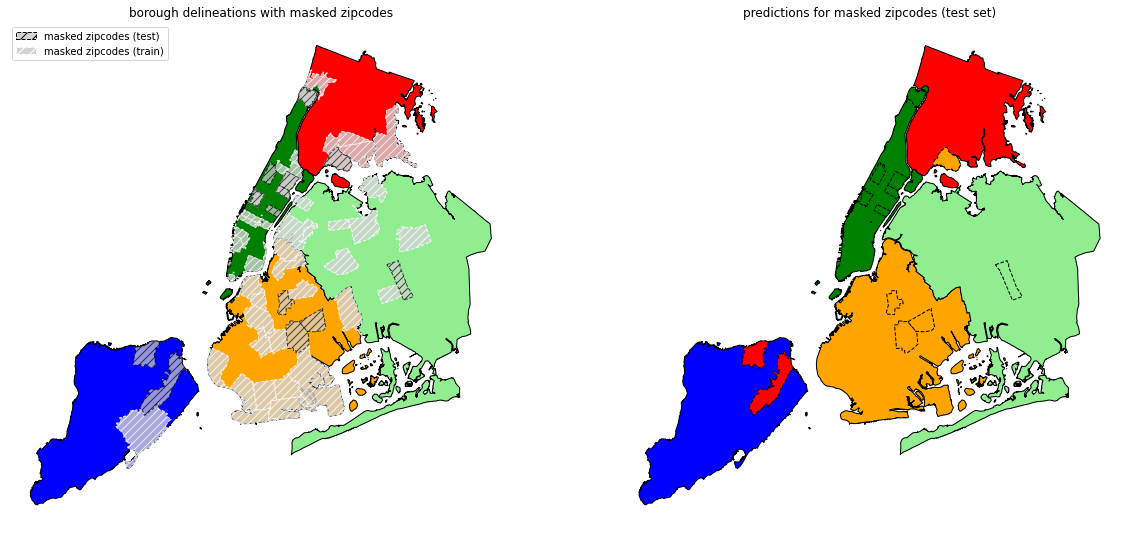

In [26]:
visualize(random_indices, test_random_indices)

### Pytorch Basics can be found here:

#### Introduction to Pytorch Tensors : https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
#### Calculating gradients using Autograd : https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html
#### Building Pytorch Models : https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
#### Training Pytorch Models : https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
